In [1]:
"""
An example of tensorboard functionalities and hyperparameter tuning using a jupyter notebook.
MNIST fashion dataset will be used as an example dataset.

The model hypertuning will be performed using keras-tuner.
An additional model to compare outputs will be created using HyperResNet parameter search.

#NOTE no extensive EDA will be included 
"""

'\nAn example of tensorboard functionalities and hyperparameter tuning using a jupyter notebook.\nMNIST fashion dataset will be used as an example dataset.\n\nThe model hypertuning will be performed using keras-tuner.\nAn additional model to compare outputs will be created using HyperResNet parameter search.\n\n#NOTE no extensive EDA will be included \n'

In [2]:
#Install tensorboard
!pip install tensorboard
#Install keras tuner
!pip install keras-tuner -q


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 28.6 MB/s 


In [3]:
#Install libraries
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorboard as tb 
from tensorflow import keras
from keras.datasets import fashion_mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


import keras_tuner

In [4]:
#Set log folder

#remove any existing logs
!rm -rf logs/
#For logging and tracking precise records set log time
log_folder='logs/fit/'+datetime.datetime.now().strftime("Y%m%d-%H%M%S")

4431872/4422102 [==============================] - 0s 0us/step
Train data (60000, 28, 28)
Test data (10000, 28, 28)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


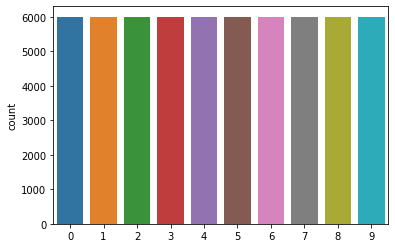

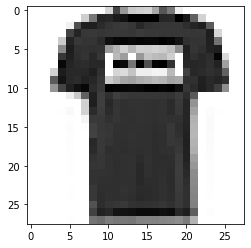

In [5]:
#Load and prepare data
(X_train,y_train),(X_test,y_test)=fashion_mnist.load_data()

#Scale data
X_train=X_train.astype('float32')/255.0
X_test=X_test.astype('float32')/255.0

print("Train data",X_train.shape)
print("Test data",X_test.shape)

#Explore data
sns.countplot(y_train)
plt.show()

img=X_train[1,:]
plt.imshow(img,cmap='binary')
plt.show()

In [6]:
#Set parameters
es=tf.keras.callbacks.EarlyStopping(patience=10,monitor='val_loss')
tb_cb=tf.keras.callbacks.TensorBoard(log_dir=log_folder,histogram_freq=1,embeddings_freq=1,write_graph=1,write_images=1,update_freq='epoch',
                                     profile_batch=2)

EPOCHS=100
INPUT_SHAPE=(28,28,1)
BATCH=256
VAL_SPLIT=0.2
NUM_CLASSES=10


In [7]:
#Build a model for hyperparameter tuning
#The model will explore several different architectures

def model_builder(hp):

  input=tf.keras.Input(shape=INPUT_SHAPE)
  #define model
  model_choice=hp.Choice('model_type',['MLP','CNN'])
  x=input

  if model_choice=='MLP':
    x=Flatten()(x)
    for i in range(hp.Int('MLP_layers',2,5)):

      x=Dense(hp.Int(f"units_{i}",16,256,step=16),activation='relu')(x)
      x=Dropout(hp.Float(f"dropout_{i}",0.1,0.5,step=0.1))(x)
  elif model_choice=="CNN":
    
    for i in range(hp.Int("Conv_blocks",1,3,step=1)):
      filters=hp.Int(f"Filters_{i}",32,256,step=32)
      x=Conv2D(filters,kernel_size=(3,3),activation='relu')(x)
      x=MaxPooling2D((2,2))(x)
    
    if hp.Choice('pooling',['Flat','MAX'])=='Flat':
      x=Flatten()(x)
    else:
      x=GlobalAveragePooling2D()(x)

    x=Dense(hp.Int("conv_units_1",64,256,step=64),activation='relu')(x)
    x=Dropout(hp.Float("conv_dropout_2",0.1,0.5,step=0.1))(x)
    x=Dense(hp.Int("conv_units_2",16,64,step=16),activation='relu')(x)

  output=Dense(NUM_CLASSES,activation='softmax')(x)

  model=tf.keras.Model(inputs=input,outputs=output)

  model.compile(loss='sparse_categorical_crossentropy',optimizer=hp.Choice('optimzer',['adam','rmsprop','sgd']),metrics=['accuracy'])
  
  return model


In [8]:
#Check model
hp=keras_tuner.HyperParameters()
hp.values['model_type']="MLP"
model=model_builder(hp)
model(X_train[:100]) #see if model can run with the data
print(model.summary())

hp.values['model_type']="CNN"
model=model_builder(hp)
model(X_train[:100]) #see if model can run with the data
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                170   

In [9]:
#Setup the tuner
tuner=keras_tuner.RandomSearch(model_builder,max_trials=10,overwrite=True,objective='val_accuracy',directory=log_folder)

In [10]:
#Search for the best model
tuner.search(X_train,y_train,validation_split=VAL_SPLIT,epochs=10,callbacks=[tb_cb]) #you can also use early stopping

Trial 10 Complete [00h 01m 23s]
val_accuracy: 0.8685833215713501

Best val_accuracy So Far: 0.9161666631698608
Total elapsed time: 00h 12m 18s


In [ ]:
#Explore tensorboard outputs
%load_ext tensorboard
%tensorboard --logdir logs

In [11]:
best_model=tuner.get_best_models(1)[0] #get the best model
best_params=tuner.get_best_hyperparameters(1)[0] #get best model parameters

print("Best parameters \n")
print(best_params.values)

Best parameters 

{'model_type': 'CNN', 'MLP_layers': 2, 'units_0': 96, 'dropout_0': 0.2, 'units_1': 192, 'dropout_1': 0.4, 'optimzer': 'adam', 'Conv_blocks': 2, 'Filters_0': 192, 'pooling': 'Flat', 'conv_units_1': 256, 'conv_dropout_2': 0.4, 'conv_units_2': 48, 'Filters_1': 224}


Epoch 1/100
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1497 - accuracy: 0.9446 - val_loss: 0.2698 - val_accuracy: 0.9088
Epoch 2/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1397 - accuracy: 0.9488 - val_loss: 0.2755 - val_accuracy: 0.9128
Epoch 3/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1300 - accuracy: 0.9519 - val_loss: 0.2558 - val_accuracy: 0.9165
Epoch 4/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1193 - accuracy: 0.9552 - val_loss: 0.2840 - val_accuracy: 0.9166
Epoch 5/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1111 - accuracy: 0.9585 - val_loss: 0.2919 - val_accuracy: 0.9174
Epoch 6/100
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1063 - accuracy: 0.9594 - val_loss: 0.3064 - val_accuracy: 0.9171
Epoch 7/100
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0977 - accuracy: 0.9633 - val_loss: 0.3252 - val_a

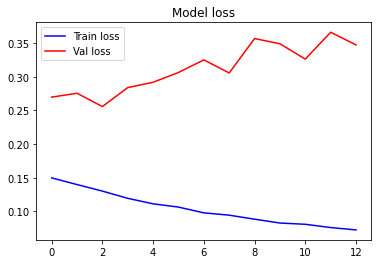

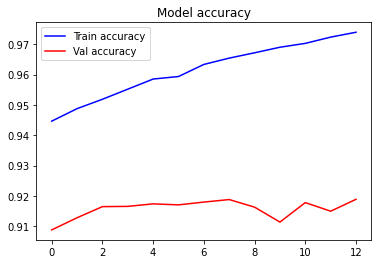

In [12]:
#Train the best parameters 
#hypermodel=tuner.hypermodel.build(best_params)
history=best_model.fit(X_train,y_train,epochs=EPOCHS,validation_split=VAL_SPLIT,callbacks=[es])

epochs=history.epoch
history=history.history

print("Best epoch",np.argmin(history['val_loss']))

plt.plot(epochs,history['loss'],'-b',label='Train loss')
plt.plot(epochs,history['val_loss'],'-r',label='Val loss')
plt.legend()
plt.title('Model loss')
plt.show()
plt.plot(epochs,history['accuracy'],'-b',label='Train accuracy')
plt.plot(epochs,history['val_accuracy'],'-r',label='Val accuracy')
plt.legend()
plt.title('Model accuracy')
plt.show()

313/313 [==============================] - 2s 6ms/step - loss: 0.3898 - accuracy: 0.9149
Model evaluation 
 [0.38978031277656555, 0.914900004863739]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1000
           1       1.00      0.98      0.99      1000
           2       0.85      0.89      0.87      1000
           3       0.91      0.94      0.92      1000
           4       0.88      0.87      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.77      0.71      0.74      1000
           7       0.95      0.98      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



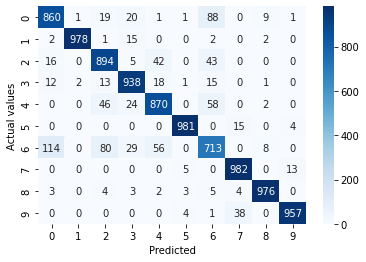

In [13]:
#Evaluate the model
results=best_model.evaluate(X_test,y_test)
print("Model evaluation \n",results)

y_pred=best_model.predict(X_test)

print(classification_report(y_test,np.argmax(y_pred,axis=1)))

sns.heatmap(confusion_matrix(y_test,np.argmax(y_pred,axis=1)),cmap='Blues',annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual values")
plt.show()

In [18]:
train_images=X_train[:,:,:,np.newaxis]
train_images.shape

(60000, 28, 28, 1)

In [19]:
train_labels = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
train_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
#Compare to a pretrained model HyperResNet
#NOTE data preprocessing is required to match input shape and label types
tuner=keras_tuner.RandomSearch(keras_tuner.applications.HyperResNet(input_shape=(28, 28, 1), classes=NUM_CLASSES),objective='val_accuracy',max_trials=3, overwrite=True) #reduce the number of trials for demonstration purposes

#Search for the best model
tuner.search(train_images,train_labels,validation_split=VAL_SPLIT,epochs=2,callbacks=[tb_cb]) #reduce the number of epochs to save time for demonstration purposes

Trial 3 Complete [00h 07m 59s]
val_accuracy: 0.7974166870117188

Best val_accuracy So Far: 0.8629166483879089
Total elapsed time: 00h 16m 11s


Best parameters 

{'version': 'v1', 'conv3_depth': 4, 'conv4_depth': 6, 'pooling': 'avg', 'optimizer': 'sgd', 'learning_rate': 0.01}
Epoch 1/20
1500/1500 [==============================] - 64s 40ms/step - loss: 0.3444 - accuracy: 0.8699 - val_loss: 0.3420 - val_accuracy: 0.8755
Epoch 2/20
1500/1500 [==============================] - 59s 40ms/step - loss: 0.3062 - accuracy: 0.8864 - val_loss: 0.3419 - val_accuracy: 0.8672
Epoch 3/20
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2763 - accuracy: 0.8957 - val_loss: 0.3765 - val_accuracy: 0.8581
Epoch 4/20
1500/1500 [==============================] - 59s 39ms/step - loss: 0.2576 - accuracy: 0.9026 - val_loss: 0.3230 - val_accuracy: 0.8813
Epoch 5/20
1500/1500 [==============================] - 59s 40ms/step - loss: 0.2349 - accuracy: 0.9116 - val_loss: 0.3344 - val_accuracy: 0.8790
Epoch 6/20
1500/1500 [==============================] - 59s 40ms/step - loss: 0.2238 - accuracy: 0.9154 - val_loss: 0.2999 - val_accuracy

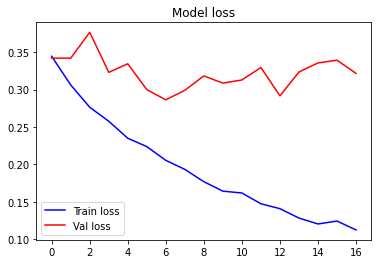

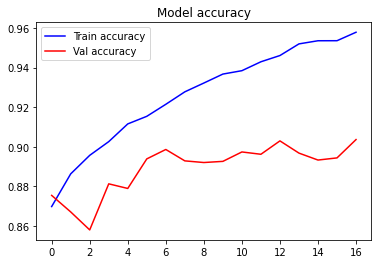

In [24]:
best_model=tuner.get_best_models(1)[0] #get the best model
best_params=tuner.get_best_hyperparameters(1)[0] #get best model parameters

print("Best parameters \n")
print(best_params.values)

#Train the best parameters 
#hypermodel=tuner.hypermodel.build(best_params)
history=best_model.fit(train_images,train_labels,epochs=20,validation_split=VAL_SPLIT,callbacks=[es])

epochs=history.epoch
history=history.history

print("Best epoch",np.argmin(history['val_loss']))

plt.plot(epochs,history['loss'],'-b',label='Train loss')
plt.plot(epochs,history['val_loss'],'-r',label='Val loss')
plt.legend()
plt.title('Model loss')
plt.show()
plt.plot(epochs,history['accuracy'],'-b',label='Train accuracy')
plt.plot(epochs,history['val_accuracy'],'-r',label='Val accuracy')
plt.legend()
plt.title('Model accuracy')
plt.show()

313/313 [==============================] - 6s 18ms/step - loss: 0.3624 - accuracy: 0.8956
Model evaluation 
 [0.36237284541130066, 0.8956000208854675]
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.83      0.85      0.84      1000
           3       0.89      0.92      0.90      1000
           4       0.82      0.83      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.69      0.71      1000
           7       0.97      0.93      0.95      1000
           8       0.96      0.98      0.97      1000
           9       0.93      0.98      0.95      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



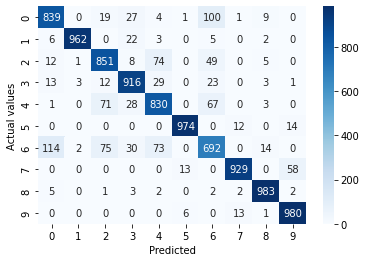

In [34]:
#Evaluate the model

test_images=X_test[:,:,:,np.newaxis]
test_labels = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)


results=best_model.evaluate(test_images,test_labels)
print("Model evaluation \n",results)

y_pred=best_model.predict(test_images)

print(classification_report(np.argmax(test_labels,axis=1),np.argmax(y_pred,axis=1)))

sns.heatmap(confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(y_pred,axis=1)),cmap='Blues',annot=True,fmt='g')
plt.xlabel("Predicted")
plt.ylabel("Actual values")
plt.show()

In [ ]:
#Explore tensorboard outputs
%load_ext tensorboard
%tensorboard --logdir logs